In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Processing results
import json

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Processing
from sklearn.preprocessing import StandardScaler

# Data imputation
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

<IPython.core.display.Javascript object>

In [3]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

In [4]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [5]:
def get_xgboost_importances(scores, importance_type="gain"):
    tree_importances = []

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances_dict = (
            model.get_booster().get_score(importance_type=importance_type).copy()
        )
        tree_importances.append(
            pd.DataFrame(
                importances_dict.values(),
                index=importances_dict.keys(),
                columns=[f"Value - {index}"],
            ).T
        )

    df_importances = pd.concat(tree_importances)

    return df_importances

<IPython.core.display.Javascript object>

In [6]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [7]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [8]:
df = pd.read_csv("../../../../data/processed/partner_i-Oficial/cement-shipping.csv")

<IPython.core.display.Javascript object>

# Chemical + Mineralogical Features

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [15]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "Initial setting time",
        "Final setting time",
        "Density",
        "#200",
        "#325",
        "CS3",
        "CS7",
        # Removing One-Hot encoding variables
        # "Remarks_CPIIF40 Expedido",
        # "Remarks_CPVARI Expedido",
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was
        # measured by a different method, namely manual
        # "LOI",
        "Alpha C2S",
        "Beta C2S",
        "Gamma C2S",
        "Cubic C3A",
        "Orthorhombic C3A",
        "Cement_Type",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

# 1. Linear Regression

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [16]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## Repeated KFold Cross validation

In [17]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -3.460 (0.048)
MAE: -2.669 (0.042)
MAPE: -0.064 (0.001)
R2: 0.529 (0.014)


******
[TEST]
******
RMSE: -3.553 (0.194)
MAE: -2.739 (0.149)
MAPE: -0.066 (0.003)
R2: 0.500 (0.061)




<IPython.core.display.Javascript object>

In [18]:
pd.concat(results_to_save).groupby(["Features", "Model", "Cross Validation"])[
    ["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]
].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features              Model Cross Validation RMSE Test  \
                                                                     mean   
0  Chemical + Mineralogical  Linear Regression   Repeated KFold   3.55293   

             MAE Test           MAPE Test             R2 Test            
        std      mean       std      mean       std      mean       std  
0  0.193948  2.738804  0.148725   0.06553  0.003375  0.499604  0.060852

<IPython.core.display.Javascript object>

In [12]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

<IPython.core.display.Javascript object>

In [19]:
df_coefs, df_bias = get_linreg_df_importances(scores)

<IPython.core.display.Javascript object>

In [25]:
df_coefs.mean().sort_values().to_frame().rename(
    {0: "Coefficient"}, axis=1
).style.background_gradient(axis=None, vmin=1, vmax=5, cmap="Greens")

,Coefficient
CaO,-1.342372
Na2O,-0.483203
Calcite,-0.360642
Quartz,-0.303137
Bassanite,-0.245566
Periclase,-0.201502
Total C3S,-0.168898
C3A,-0.165196
Portlandite,-0.162263
C4AF,-0.091987


<IPython.core.display.Javascript object>

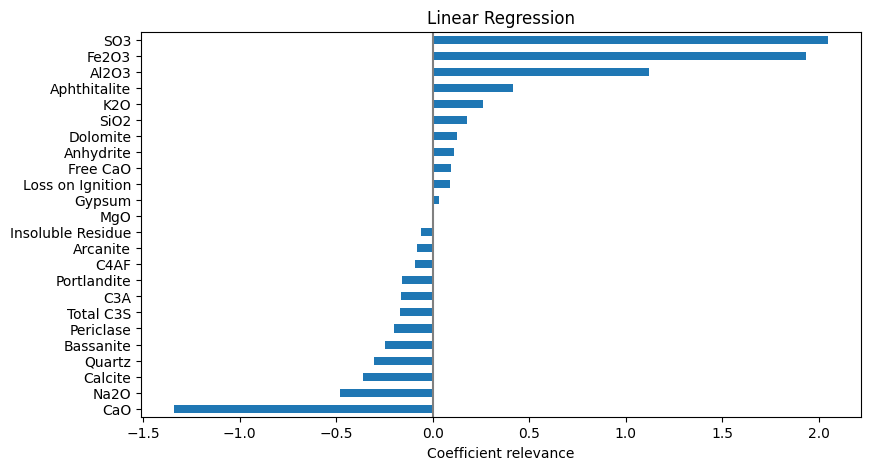

<IPython.core.display.Javascript object>

In [26]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 5))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.subplots_adjust(left=0.3)

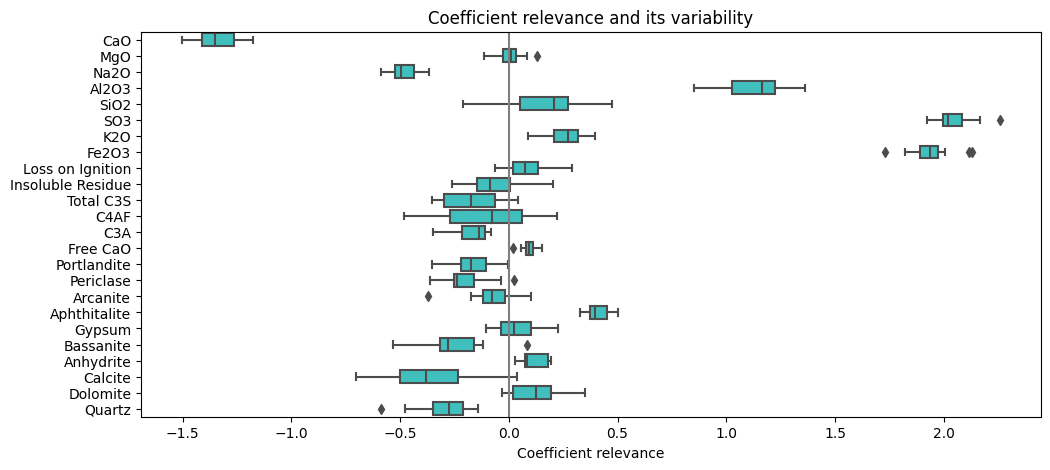

<IPython.core.display.Javascript object>

In [27]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 5))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.title("Coefficient relevance and its variability")
plt.subplots_adjust(left=0.3)

In [28]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,15.0,-1.342372,0.103284,-1.503761,-1.410910,-1.351306,-1.262975,-1.175215
MgO,15.0,0.008502,0.058925,-0.112892,-0.026857,0.009642,0.033833,0.128295
Na2O,15.0,-0.483203,0.062648,-0.586370,-0.525557,-0.494251,-0.434010,-0.366182
Al2O3,15.0,1.119623,0.147787,0.851476,1.024323,1.164482,1.223894,1.363636
SiO2,15.0,0.176478,0.168947,-0.211642,0.049267,0.209182,0.274370,0.476515
SO3,15.0,2.048391,0.090685,1.924232,1.994726,2.022187,2.085586,2.259469
K2O,15.0,0.261585,0.083901,0.088645,0.208736,0.274140,0.319833,0.394342
Fe2O3,15.0,1.933957,0.104688,1.728046,1.888970,1.935207,1.974535,2.131263
Loss on Ignition,15.0,0.090982,0.109266,-0.062165,0.021224,0.072443,0.133888,0.288402
Insoluble Residue,15.0,-0.060476,0.136912,-0.260175,-0.148557,-0.085859,0.005464,0.202237


<IPython.core.display.Javascript object>

# 1. XGBoost

In [20]:
# Modeling
from xgboost import XGBRegressor
from xgboost import plot_importance

<IPython.core.display.Javascript object>

In [21]:
PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
    "verbosity": 0,
    "silent": True,
}

<IPython.core.display.Javascript object>

## Blocking Time Series Cross Validation

In [22]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.263 (0.178)
MAE: -1.741 (0.131)
MAPE: -0.042 (0.003)
R2: 0.799 (0.016)


******
[TEST]
******
RMSE: -3.271 (0.427)
MAE: -2.477 (0.304)
MAPE: -0.059 (0.008)
R2: 0.546 (0.133)




/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

<IPython.core.display.Javascript object>

   1. Weight: Reflects the number of times a feature is used to split the data across all trees.
   
   
   2. Gain: Measures the improvement in accuracy brought by a feature to the branches it is on. This is relevant for regression with squared error, as it directly reflects the reduction in the squared error.
   
   3. Cover: Represents the relative quantity of observations concerned by a feature.

https://xgboost.readthedocs.io/en/stable/python/python_api.html

https://forecastegy.com/posts/xgboost-feature-importance-python/

1. ‘weight’: the number of times a feature is used to split the data across all trees.

2.  ‘gain’: the average gain across all splits the feature is used in.

3.  ‘cover’: the average coverage across all splits the feature is used in.

4. ‘total_gain’: the total gain across all splits the feature is used in.

5.  ‘total_cover’: the total coverage across all splits the feature is used in.


In [23]:
df_importances = get_xgboost_importances(scores, importance_type="gain")

<IPython.core.display.Javascript object>

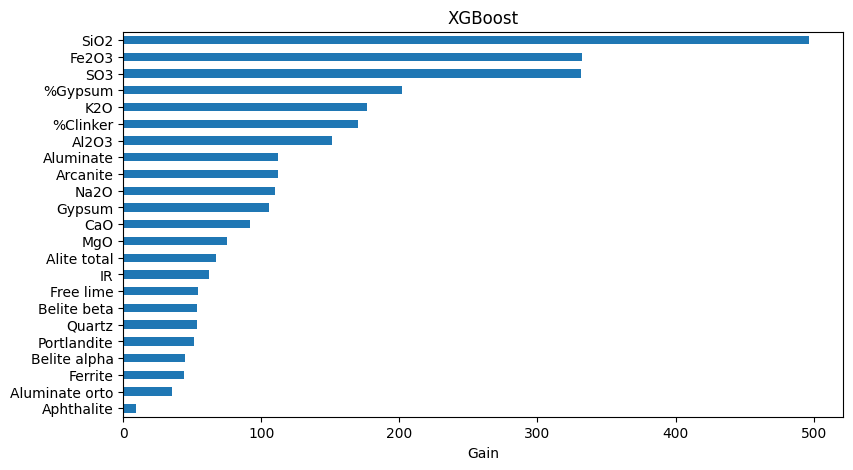

<IPython.core.display.Javascript object>

In [24]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("XGBoost")
plt.xlabel("Gain")
plt.subplots_adjust(left=0.3)

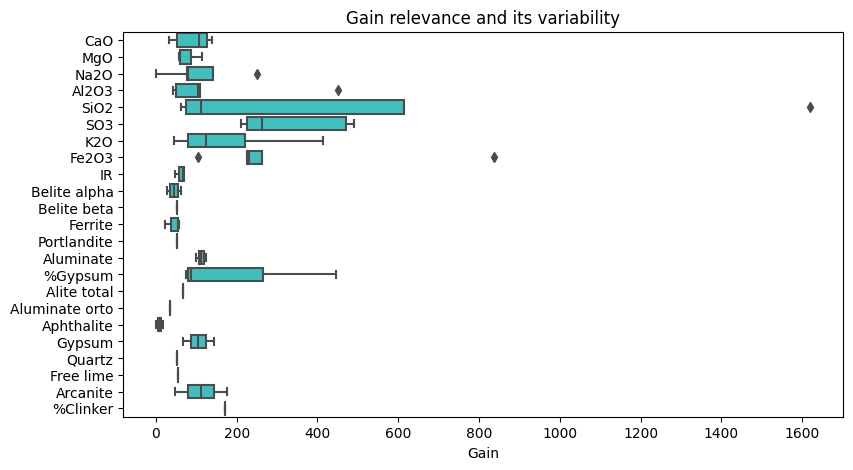

<IPython.core.display.Javascript object>

In [25]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Gain")
plt.title("Gain relevance and its variability")
plt.subplots_adjust(left=0.3)

In [26]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,91.500337,46.514278,33.304443,52.148727,106.596252,125.944466,139.507797
MgO,5.0,75.247762,25.161568,57.396072,58.509827,59.064491,86.800644,114.467773
Na2O,5.0,109.570380,93.076693,0.166355,76.632751,80.392410,140.384262,250.276123
Al2O3,5.0,150.875122,170.915182,41.164711,49.734375,103.416290,108.321342,451.738892
SiO2,5.0,496.628303,669.135256,61.645786,75.529358,112.016113,613.563293,1620.386963
SO3,5.0,331.679523,136.814318,211.612961,224.577530,262.305695,469.841461,490.059967
K2O,4.0,176.420839,164.757660,44.848251,78.649172,123.596081,221.367748,413.642944
Fe2O3,5.0,332.109592,288.438779,105.255066,224.902649,230.465286,263.100067,836.824890
IR,3.0,61.937436,12.582119,47.442078,57.888409,68.334740,69.185116,70.035492
Belite alpha,2.0,44.724415,25.671771,26.571732,35.648073,44.724415,53.800756,62.877098


<IPython.core.display.Javascript object>

# Chemical + Mineralogical + Physical Features

In [27]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + CS3 + CS7",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Linear Regression

## Defining Features

In this set of experiments we keep all features

In [28]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "Initial setting time",
        "Final setting time",
        "Density",
        "#200",
        "#325",
        # "#400",
        # Removing One-Hot encoding variables
        "Remarks_CPIIF40 Expedido",
        "Remarks_CPVARI Expedido",
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was
        # measured by a different method, namely manual
        "LOI",
    ],
    axis=1,
).copy()


<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [29]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation


In [30]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.981 (0.009)
MAE: -0.767 (0.005)
MAPE: -0.018 (0.000)
R2: 0.962 (0.001)


******
[TEST]
******
RMSE: -1.065 (0.094)
MAE: -0.803 (0.027)
MAPE: -0.019 (0.001)
R2: 0.955 (0.009)




<IPython.core.display.Javascript object>

In [31]:
df_coefs, df_bias = get_linreg_df_importances(scores)

<IPython.core.display.Javascript object>

In [32]:
df_coefs.mean().sort_values().to_frame().style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,0
%Limestone,-2.298570
%Clinker,-1.956768
Aluminate orto,-0.520454
%Gypsum,-0.478316
Alite total,-0.411805
Aluminate cubic,-0.373571
Calcite,-0.224645
Belite beta,-0.203399
Periclase,-0.155923
Na2O,-0.113784


<IPython.core.display.Javascript object>

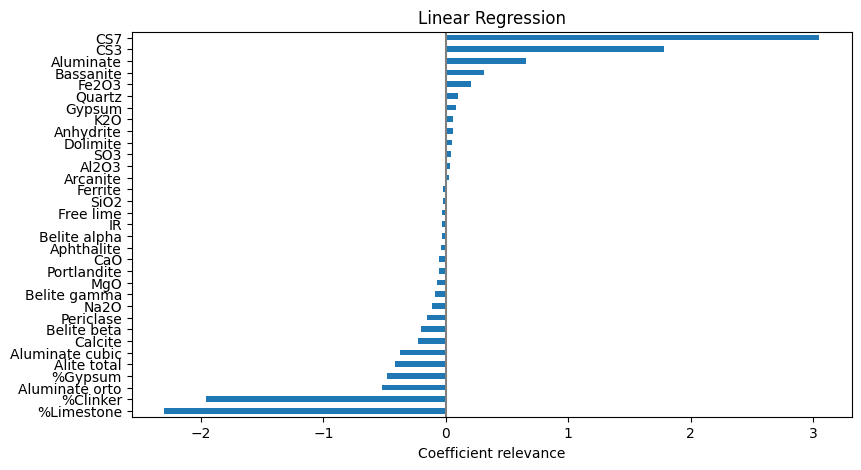

<IPython.core.display.Javascript object>

In [33]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 5))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.subplots_adjust(left=0.3)

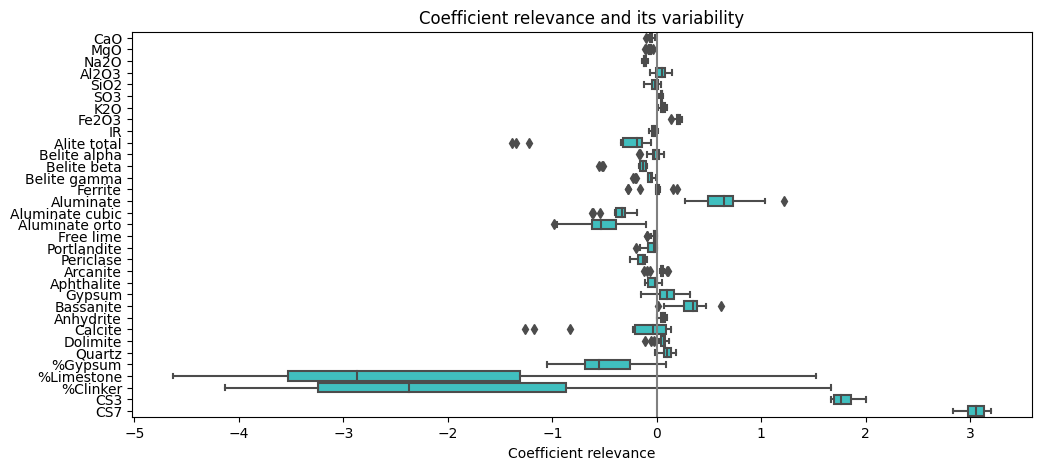

<IPython.core.display.Javascript object>

In [34]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 5))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.title("Coefficient relevance and its variability")
plt.subplots_adjust(left=0.3)

In [35]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,15.0,-0.055028,0.022692,-0.107965,-0.064873,-0.051918,-0.041389,-0.018557
MgO,15.0,-0.068851,0.020903,-0.117446,-0.073158,-0.065816,-0.058311,-0.034875
Na2O,15.0,-0.113784,0.016923,-0.141061,-0.125611,-0.117801,-0.102846,-0.083579
Al2O3,15.0,0.035794,0.061508,-0.062377,-0.011382,0.047344,0.078987,0.145270
SiO2,15.0,-0.023884,0.048975,-0.121073,-0.049044,-0.018020,0.007724,0.040127
SO3,15.0,0.043660,0.011129,0.023814,0.036169,0.047512,0.052886,0.057371
K2O,15.0,0.060290,0.024388,0.013433,0.043355,0.059291,0.074045,0.102109
Fe2O3,15.0,0.202002,0.030467,0.139612,0.191240,0.201046,0.222804,0.243629
IR,15.0,-0.027685,0.026617,-0.075538,-0.046690,-0.023090,-0.004523,0.008556
Alite total,15.0,-0.411805,0.476859,-1.385150,-0.324904,-0.186130,-0.145414,-0.056709


<IPython.core.display.Javascript object>

# Random Forest

## Defining a dataframe structure to save the results

In [44]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}


<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [45]:
df_copy = df.drop(
    [  # Removing One-Hot encoding variables
        "Remarks_CPIIF40 Expedido",
        "Remarks_CPVARI Expedido",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

In [46]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [47]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

In [50]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.762 (0.069)
MAE: -0.569 (0.058)
MAPE: -0.013 (0.001)
R2: 0.977 (0.003)


******
[TEST]
******
RMSE: -1.011 (0.269)
MAE: -0.774 (0.196)
MAPE: -0.018 (0.005)
R2: 0.956 (0.022)




<IPython.core.display.Javascript object>

In [51]:
df_importances = get_random_forest_df_importances(scores)
df_importances = df_importances.rename(
    {
        "unified_material_name_Type III": "Cem Type A",
        "unified_material_name_Type IL": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

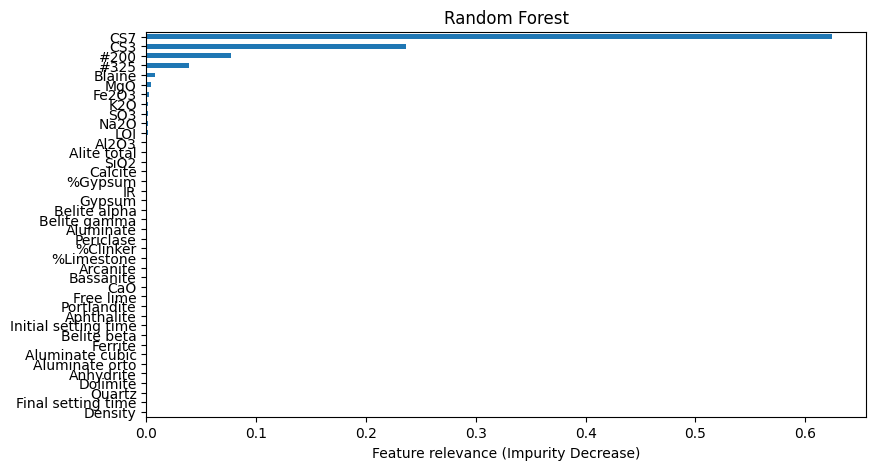

<IPython.core.display.Javascript object>

In [57]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("Random Forest")
plt.xlabel("Feature relevance (Impurity Decrease)")
plt.subplots_adjust(left=0.3)

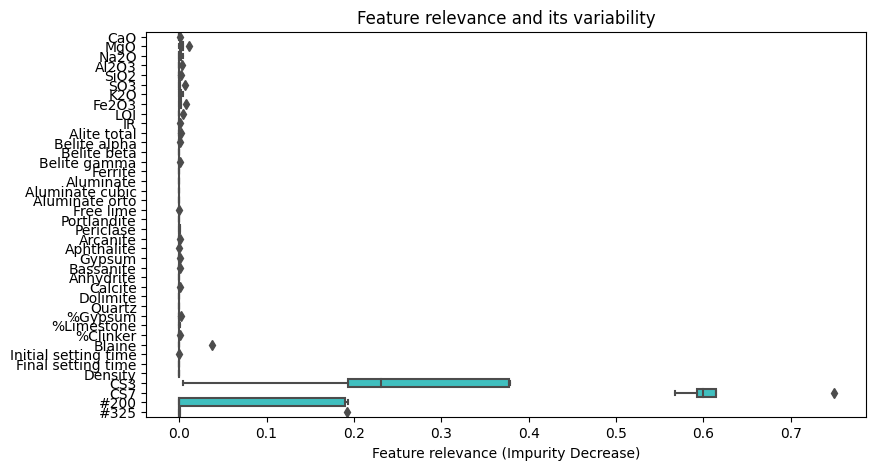

<IPython.core.display.Javascript object>

In [58]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Feature relevance (Impurity Decrease)")
plt.title("Feature relevance and its variability")
plt.subplots_adjust(left=0.3)

In [56]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.000094,0.000211,0.000000,0.000000,0.000000,0.000000,0.000472
MgO,5.0,0.003923,0.004467,0.000000,0.000578,0.003251,0.004632,0.011154
Na2O,5.0,0.001257,0.001949,0.000000,0.000000,0.000000,0.001848,0.004435
Al2O3,5.0,0.000676,0.001386,0.000000,0.000000,0.000000,0.000232,0.003149
SiO2,5.0,0.000346,0.000747,0.000000,0.000000,0.000000,0.000047,0.001681
SO3,5.0,0.001477,0.002905,0.000000,0.000000,0.000311,0.000412,0.006663
K2O,5.0,0.001538,0.001705,0.000000,0.000000,0.001293,0.002389,0.004010
Fe2O3,5.0,0.002061,0.003395,0.000000,0.000000,0.000498,0.001822,0.007986
LOI,5.0,0.001038,0.002114,0.000000,0.000000,0.000154,0.000222,0.004816
IR,5.0,0.000308,0.000492,0.000000,0.000000,0.000000,0.000409,0.001129


<IPython.core.display.Javascript object>

# Chemical + Mineralogical + Cement Type

# Linear Regression

## Defining a dataframe structure to save the results

In [43]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [44]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "Initial setting time",
        "Final setting time",
        "Density",
        "#200",
        "#325",
        "CS3",
        "CS7",
        
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was 
        # measured by a different method, namely manual
        "LOI"
    ],
    axis=1,
).copy()


<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [45]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation


In [46]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.871 (0.101)
MAE: -0.679 (0.080)
MAPE: -0.016 (0.002)
R2: 0.970 (0.005)


******
[TEST]
******
RMSE: -1.000 (0.181)
MAE: -0.771 (0.111)
MAPE: -0.018 (0.002)
R2: 0.958 (0.013)




<IPython.core.display.Javascript object>

In [47]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_coefs = df_coefs.rename(
    {"Remarks_CPIIF40 Expedido": "Cem Type A", "Remarks_CPVARI Expedido": "Cem Type B"},
    axis=1,
)

<IPython.core.display.Javascript object>

In [48]:
df_coefs.mean().sort_values().to_frame().style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,0
%Limestone,-13.800364
%Gypsum,-3.587280
Aluminate orto,-2.465779
Alite total,-1.225614
SiO2,-0.527256
Belite alpha,-0.333391
Periclase,-0.214013
K2O,-0.130114
Free lime,-0.113731
MgO,-0.040745


<IPython.core.display.Javascript object>

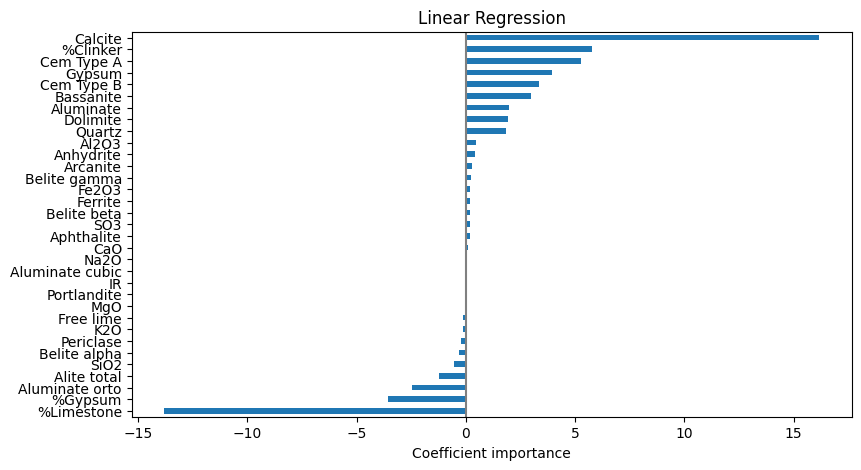

<IPython.core.display.Javascript object>

In [49]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 5))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.subplots_adjust(left=0.3)

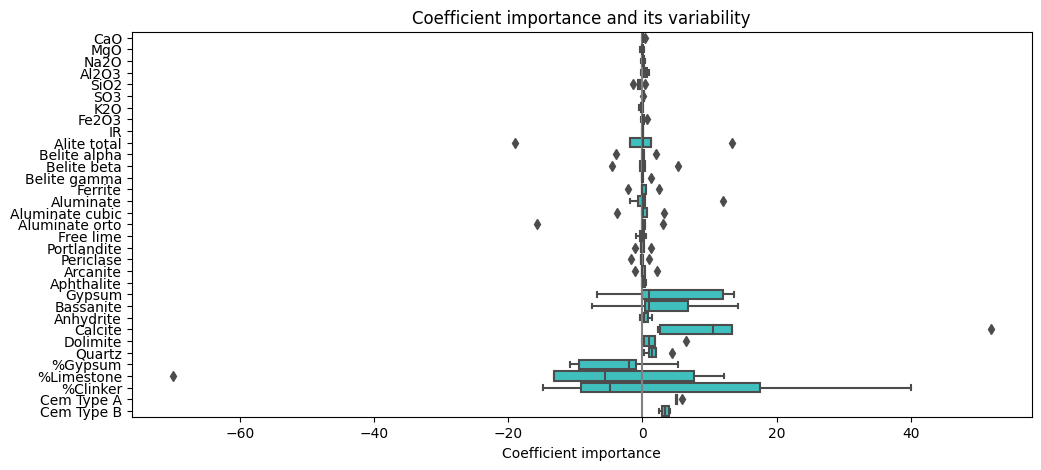

<IPython.core.display.Javascript object>

In [50]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 5))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

In [51]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.103818,0.148064,-0.030207,0.034298,0.064266,0.095397,0.355335
MgO,5.0,-0.040745,0.224459,-0.360260,-0.136338,0.000746,0.049155,0.242973
Na2O,5.0,0.067119,0.230233,-0.181370,-0.092979,0.028614,0.182909,0.398419
Al2O3,5.0,0.454527,0.446464,-0.186940,0.226816,0.591997,0.666447,0.974315
SiO2,5.0,-0.527256,0.626886,-1.379991,-0.628976,-0.578894,-0.427735,0.379313
SO3,5.0,0.177305,0.090242,0.028653,0.155251,0.222304,0.234470,0.245849
K2O,5.0,-0.130114,0.257452,-0.517852,-0.188517,-0.150808,0.071853,0.134755
Fe2O3,5.0,0.183780,0.317107,-0.203526,0.033976,0.154952,0.281263,0.652233
IR,5.0,0.002051,0.078664,-0.092651,-0.074472,0.050805,0.058226,0.068347
Alite total,5.0,-1.225614,11.597179,-19.074538,-1.804539,0.135439,1.325777,13.289789


<IPython.core.display.Javascript object>

# XGBoost

## Defining a dataframe structure to save the results

In [52]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "XGBoost",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": None,
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [53]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "Initial setting time",
        "Final setting time",
        "Density",
        "#200",
        "#325",
        "CS3",
        "CS7",
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was
        # measured by a different method, namely manual
        "LOI",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [54]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [55]:
PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
    "verbosity": 0,
    "silent": True,
}

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

In [56]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.162 (0.116)
MAE: -0.926 (0.094)
MAPE: -0.022 (0.002)
R2: 0.947 (0.006)


******
[TEST]
******
RMSE: -1.310 (0.184)
MAE: -1.055 (0.131)
MAPE: -0.025 (0.003)
R2: 0.928 (0.016)




/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

<IPython.core.display.Javascript object>

In [57]:
df_importances = get_xgboost_importances(scores, importance_type="gain")
df_importances = df_importances.rename(
    {"Remarks_CPIIF40 Expedido": "Cem Type A", "Remarks_CPVARI Expedido": "Cem Type B"},
    axis=1,
)

<IPython.core.display.Javascript object>

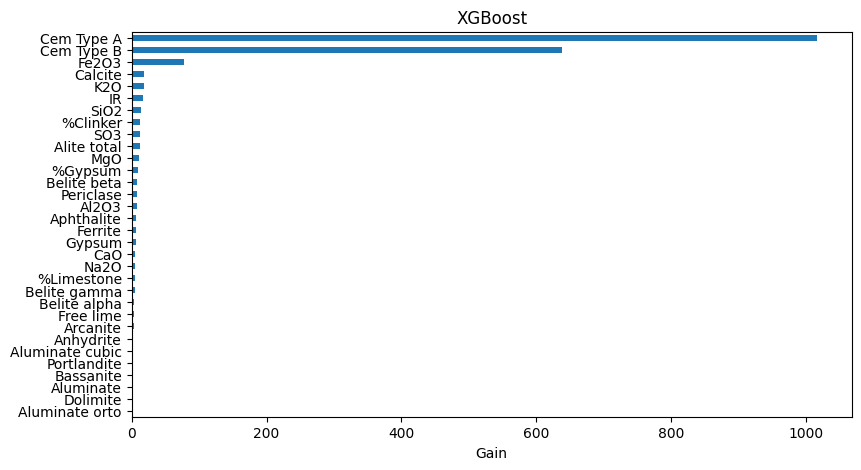

<IPython.core.display.Javascript object>

In [58]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("XGBoost")
plt.xlabel("Gain")
plt.subplots_adjust(left=0.3)

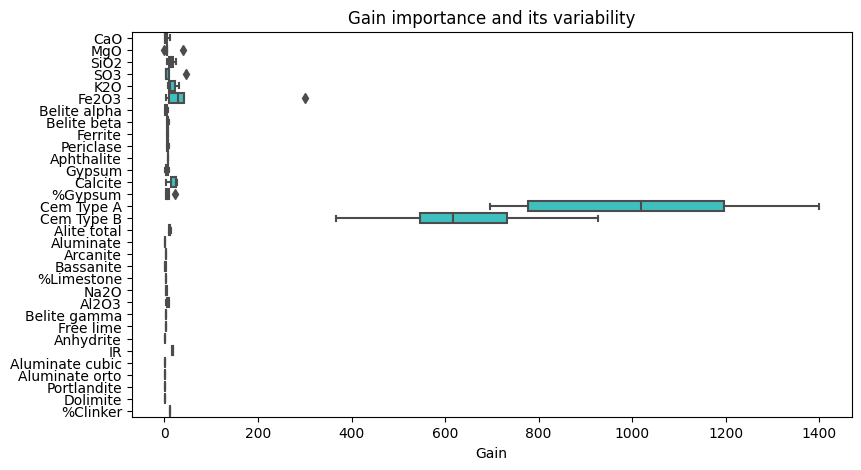

<IPython.core.display.Javascript object>

In [59]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Gain")
plt.title("Gain importance and its variability")
plt.subplots_adjust(left=0.3)

In [60]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,3.0,4.840445,5.390707,1.256866,1.740679,2.224491,6.632234,11.039976
MgO,5.0,11.503641,15.956841,0.184590,5.681467,5.947998,5.999398,39.704750
SiO2,2.0,14.410411,13.711133,4.715176,9.562793,14.410411,19.258029,24.105646
SO3,5.0,12.829569,18.277580,2.489578,3.402857,4.031616,9.013173,45.210621
K2O,3.0,17.724225,12.674496,8.270874,10.523056,12.775238,22.450901,32.126564
Fe2O3,5.0,77.241409,125.353624,3.009811,10.566322,29.926163,43.005680,299.699066
Belite alpha,2.0,3.992165,5.056554,0.416641,2.204403,3.992165,5.779926,7.567688
Belite beta,3.0,7.735387,2.183939,6.236794,6.482494,6.728195,8.484684,10.241173
Ferrite,2.0,6.917515,2.467175,5.172958,6.045237,6.917515,7.789793,8.662071
Periclase,2.0,7.582499,3.277498,5.264957,6.423728,7.582499,8.741269,9.900040


<IPython.core.display.Javascript object>

# Chemical + Mineralogical + Physical + Cement Type

# Linear Regression

## Defining a dataframe structure to save the results

In [61]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + CS7 + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining the Features

In [62]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "Initial setting time",
        "Final setting time",
        "Density",
        "#200",
        "#325",
        # "#400",
        "CS3",
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was
        # measured by a different method, namely manual
        "LOI",
    ],
    axis=1,
).copy()

y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

In [63]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.860 (0.005)
MAE: -0.681 (0.005)
MAPE: -0.016 (0.000)
R2: 0.971 (0.000)


******
[TEST]
******
RMSE: -0.906 (0.035)
MAE: -0.711 (0.022)
MAPE: -0.016 (0.000)
R2: 0.967 (0.003)




<IPython.core.display.Javascript object>

In [64]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_coefs = df_coefs.rename(
    {"Remarks_CPIIF40 Expedido": "Cem Type A", "Remarks_CPVARI Expedido": "Cem Type B"},
    axis=1,
)

<IPython.core.display.Javascript object>

In [65]:
df_coefs.mean().sort_values().to_frame().style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,0
Aluminate orto,-0.644749
Aluminate cubic,-0.469568
SiO2,-0.317695
MgO,-0.156902
Periclase,-0.121404
Alite total,-0.102781
K2O,-0.101215
Belite gamma,-0.091250
%Gypsum,-0.065031
Belite beta,-0.064086


<IPython.core.display.Javascript object>

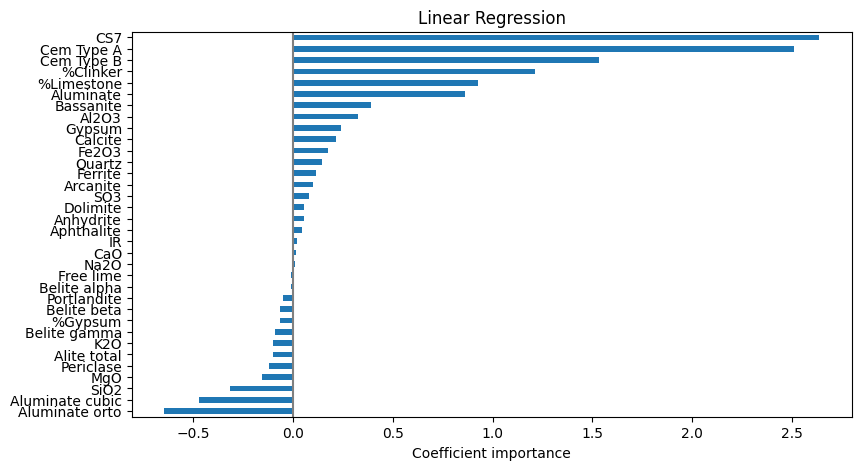

<IPython.core.display.Javascript object>

In [66]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 5))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.subplots_adjust(left=0.3)

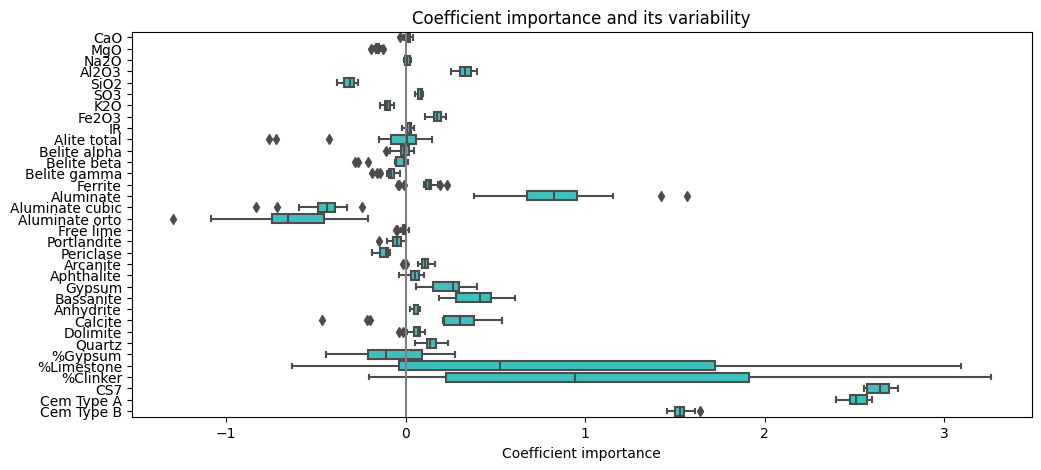

<IPython.core.display.Javascript object>

In [67]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 5))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

In [68]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,15.0,0.015322,0.018141,-0.030488,0.006960,0.020162,0.024034,0.038123
MgO,15.0,-0.156902,0.017297,-0.193049,-0.164541,-0.159266,-0.148902,-0.124274
Na2O,15.0,0.008724,0.012716,-0.008093,-0.002137,0.005015,0.021892,0.027650
Al2O3,15.0,0.327151,0.041838,0.251580,0.300948,0.327835,0.362853,0.394752
SiO2,15.0,-0.317695,0.035731,-0.381810,-0.343171,-0.309482,-0.289715,-0.267090
SO3,15.0,0.079498,0.014071,0.054316,0.068682,0.085698,0.089417,0.097191
K2O,15.0,-0.101215,0.020953,-0.141584,-0.112761,-0.104936,-0.089926,-0.063639
Fe2O3,15.0,0.175105,0.035473,0.110022,0.156371,0.176920,0.199372,0.224515
IR,15.0,0.018507,0.020934,-0.022773,0.007671,0.023320,0.032196,0.046064
Alite total,15.0,-0.102781,0.292739,-0.758960,-0.084410,0.005792,0.055999,0.146575


<IPython.core.display.Javascript object>

# XGBoost

## Defining a dataframe structure to save the results

In [69]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + CS3 + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "XGBoost",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": None,
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [70]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "Initial setting time",
        "Final setting time",
        "Density",
        "#200",
        "#325",
        "CS7",
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was
        # measured by a different method, namely manual
        "LOI",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

In [71]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [72]:
PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
    "verbosity": 0,
    "silent": True,
}

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

In [73]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.140 (0.077)
MAE: -0.918 (0.064)
MAPE: -0.022 (0.002)
R2: 0.949 (0.003)


******
[TEST]
******
RMSE: -1.360 (0.286)
MAE: -1.027 (0.187)
MAPE: -0.025 (0.004)
R2: 0.921 (0.030)




/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

<IPython.core.display.Javascript object>

In [74]:
df_importances = get_xgboost_importances(scores, importance_type="gain")
df_importances = df_importances.rename(
    {"Remarks_CPIIF40 Expedido": "Cem Type A", "Remarks_CPVARI Expedido": "Cem Type B"},
    axis=1,
)

<IPython.core.display.Javascript object>

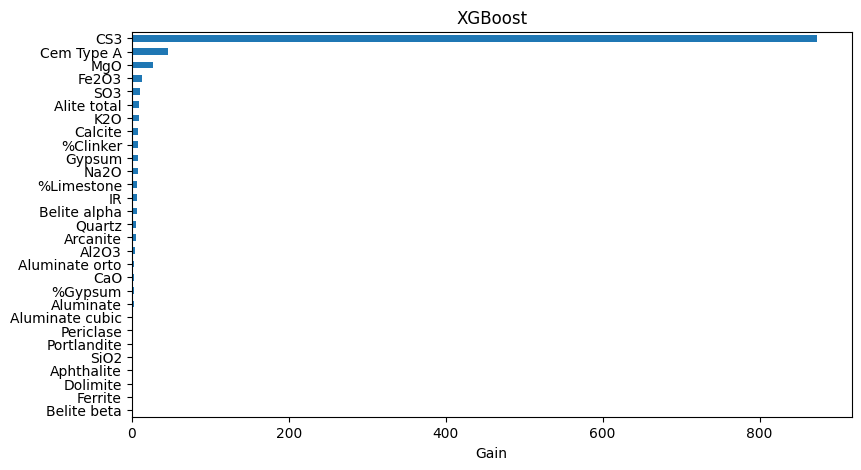

<IPython.core.display.Javascript object>

In [75]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("XGBoost")
plt.xlabel("Gain")
plt.subplots_adjust(left=0.3)

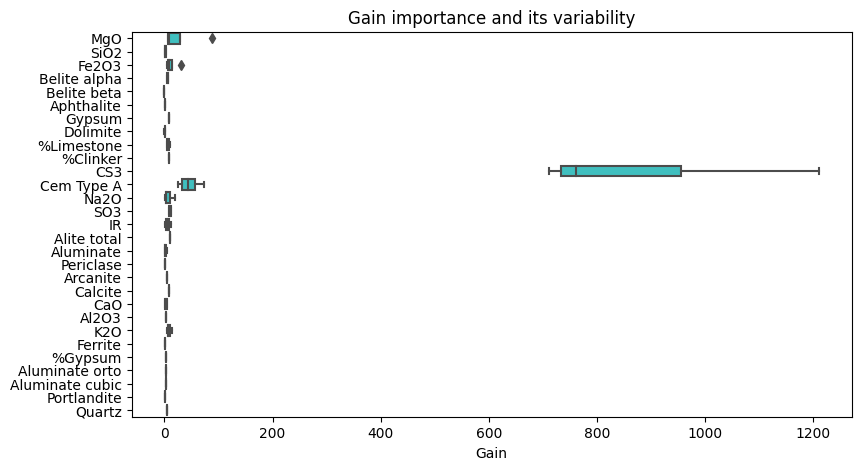

<IPython.core.display.Javascript object>

In [76]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Gain")
plt.title("Gain importance and its variability")
plt.subplots_adjust(left=0.3)

In [77]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
MgO,4.0,27.607035,39.909615,6.321694,6.591190,8.343349,29.359194,87.419746
SiO2,2.0,1.806240,1.025686,1.080971,1.443605,1.806240,2.168875,2.531509
Fe2O3,4.0,12.629916,11.878311,4.022095,5.930753,8.206326,14.905489,30.084915
Belite alpha,3.0,6.176160,1.198988,4.927841,5.604828,6.281815,6.800320,7.318825
Belite beta,1.0,0.281067,NaN,0.281067,0.281067,0.281067,0.281067,0.281067
Aphthalite,1.0,1.064438,NaN,1.064438,1.064438,1.064438,1.064438,1.064438
Gypsum,1.0,8.039185,NaN,8.039185,8.039185,8.039185,8.039185,8.039185
Dolimite,2.0,0.948948,1.040155,0.213448,0.581198,0.948948,1.316698,1.684448
%Limestone,2.0,7.165070,4.173371,4.214050,5.689560,7.165070,8.640579,10.116089
%Clinker,2.0,8.177647,0.282207,7.978096,8.077871,8.177647,8.277422,8.377197


<IPython.core.display.Javascript object>